In [ ]:

import numpy as np
import math 
import warnings
import scipy
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from IPython import get_ipython
import soundfile
import librosa
import librosa.display
import numpy as np
import pandas as pd 
from scipy.io import wavfile
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as vision
import torch.nn.functional as F
from torch.nn import MSELoss

In [ ]:
import soundfile as sf
print(sf.__file__)
print(sf._libname)

C:\Users\aseth\.conda\envs\liu\lib\site-packages\soundfile.py
C:\Users\aseth\.conda\envs\liu\Library\bin\sndfile.dll


In [ ]:
!pip install pydub

In [ ]:
# df=pd.read_csv("C:\\Users\\aseth\\Desktop\\accel_path (1).csv")
df=pd.read_csv("D:\\aseth_data\\path_set (1).csv")

In [ ]:
print(df.head())

                                                Path label  no of flutes  \
0  C:\Users\aseth\Desktop\audio_coolant_wav\s-600...     N             4   
1  C:\Users\aseth\Desktop\audio_coolant_wav\s-600...     N             4   
2  C:\Users\aseth\Desktop\audio_coolant_wav\s-600...     I             4   
3  C:\Users\aseth\Desktop\audio_coolant_wav\s-600...     Y             4   
4  C:\Users\aseth\Desktop\audio_coolant_wav\s-600...     Y             4   

      t  Unnamed: 4 Unnamed: 5  
0  t=50         NaN        NaN  
1  t=50         NaN        NaN  
2  t=50         NaN        NaN  
3  t=50         NaN        NaN  
4  t=50         NaN        NaN  


In [ ]:
s=df.iloc[138,0]
print(s)
y,sr=librosa.load(s)
y=y[20000:35000]

C:\Users\aseth\Desktop\audio_coolant_wav\s9000f100d4t50N2.wav


[[-1.19035935e+00+0.0000000e+00j -7.15231776e-01+0.0000000e+00j
  -2.18607828e-01+0.0000000e+00j ... -1.92331612e-01+0.0000000e+00j
   2.43923113e-01+0.0000000e+00j  1.20016563e+00+0.0000000e+00j]
 [ 1.17953467e+00+5.9849132e-02j  2.76164841e-02+3.9481661e-01j
   2.84192115e-01+8.5507616e-02j ...  1.64625540e-01+5.8469202e-02j
   2.40954816e-01+3.7172827e-01j -1.18212914e+00+6.0833919e-01j]
 [-1.33706319e+00-4.3513030e-01j  4.55189347e-01+2.9917112e-01j
   2.15118676e-02+1.9423842e-01j ... -2.17348129e-01-1.2339591e-01j
  -2.65772611e-01+6.4002335e-01j  1.05583644e+00-1.0886906e+00j]
 ...
 [-1.68393046e-01+2.7474976e-05j  8.42109844e-02-1.8124867e-05j
  -7.92192368e-05+2.5975742e-05j ... -9.55384239e-05+1.0607180e-04j
  -2.02453230e-02-2.6461540e-02j  6.90018311e-02+8.9874670e-02j]
 [ 1.68386444e-01-9.5504138e-06j  3.19623132e-06-8.4156126e-02j
   4.87787620e-05-3.1059524e-05j ...  2.44052317e-05-1.7998795e-05j
   1.46355508e-02-2.9889103e-02j -1.01665124e-01-5.0055031e-02j]
 [-1.68392

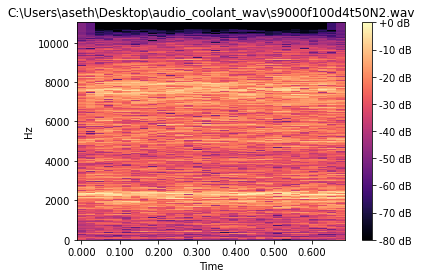

In [ ]:
value_df=pd.DataFrame()
D=librosa.stft(y)
print(D)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
# fig, ax = plt.subplots()
# img = librosa.display.specshow(S_db, ax=ax)
# fig.colorbar(img, ax=ax)
fig, ax = plt.subplots()
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title=s)
fig.colorbar(img, ax=ax, format="%+2.f dB")
# librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max), x_axis='time')
print(len(y))


In [ ]:
for i in range (0,len(df)):
    s=df.iloc[i,2]
    print(s)
    y,sr=librosa.load(s)
    D=librosa.stft(y)
    librosa.display.specshow(librosa.amplitude_to_db(D,ref=np.max), x_axis='time')

    s=np.array(s)
    print(s)
    s=[]
    k=abs(y)
    for i in range (0,len(y)-100):
        s.append(sum(k[i:i+100]))
    d=[]
    for j in range (1,len(y)):
        d.append(k[j]-k[j-1])
    d=np.array(d)
    print(d)
    print(np.argmax(d)/sr)
    sec_val=np.argmax(d)
    mse_loss=MSELoss()
    a=y[sec_val:sec_val+2200]
    a=librosa.stft(a)
    a=abs(a)
    a=a.flatten()
    imp=len(a.flatten())
    print(imp)
    print(sum(a))
    
    class Model(nn.Module):

        def __init__(self):
            super(Model, self).__init__()
            self.l1=nn.Linear(in_features=imp,out_features=1000)
            self.l2=nn.Linear(in_features=1000,out_features=200)
            self.l3=nn.Linear(in_features=200,out_features=20)
            self.d4=nn.Linear(in_features=20,out_features=imp)

        def forward(self, x):
            x = F.selu(self.l1(x))
            x = F.selu(self.l2(x))
            y=self.l3(x)
            z = F.selu(y)
            
            x=self.d4(z)

            return x,y,z

    model=Model()
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
    model.cuda()
    a=torch.Tensor(a)    
    a=a.to("cuda")
    print(a.device)
    for step in range(0,200):
        pre,need,z= model.forward(a)
        optimizer.zero_grad()
        cost=mse_loss(pre,a)
        cost.backward()
        optimizer.step()
    
    print(cost)
    s=pd.Series(need.cpu().detach().numpy())
    value_df=value_df.append(s,ignore_index=True)   



4


TypeError: Invalid file: 4